In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np # for data manipulation
import tensorflow as tf
import seaborn as sns

# Sklearn
from sklearn.linear_model import LinearRegression # for building a linear regression model
from sklearn.svm import SVR, SVC # for building SVR model
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Visualizations
import plotly.graph_objects as go # for data visualization
import plotly.express as px # for data visualization
import plotly
import plotly.graph_objs as go

from tabulate import tabulate
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import to_categorical

**VISUALIZACIÓN DE DATOS**

        Date        Open        High         Low       Close    Volume
0 2014-09-25  423.156006  423.519989  409.467987  411.574005  26814400
1 2014-09-26  411.428986  414.937988  400.009003  404.424988  21460800
2 2014-09-27  403.556000  406.622986  397.372009  399.519989  15029300
3 2014-09-28  399.471008  401.016998  374.332001  377.181000  23613300
4 2014-09-29  376.928009  385.210999  372.239990  375.467010  32497700


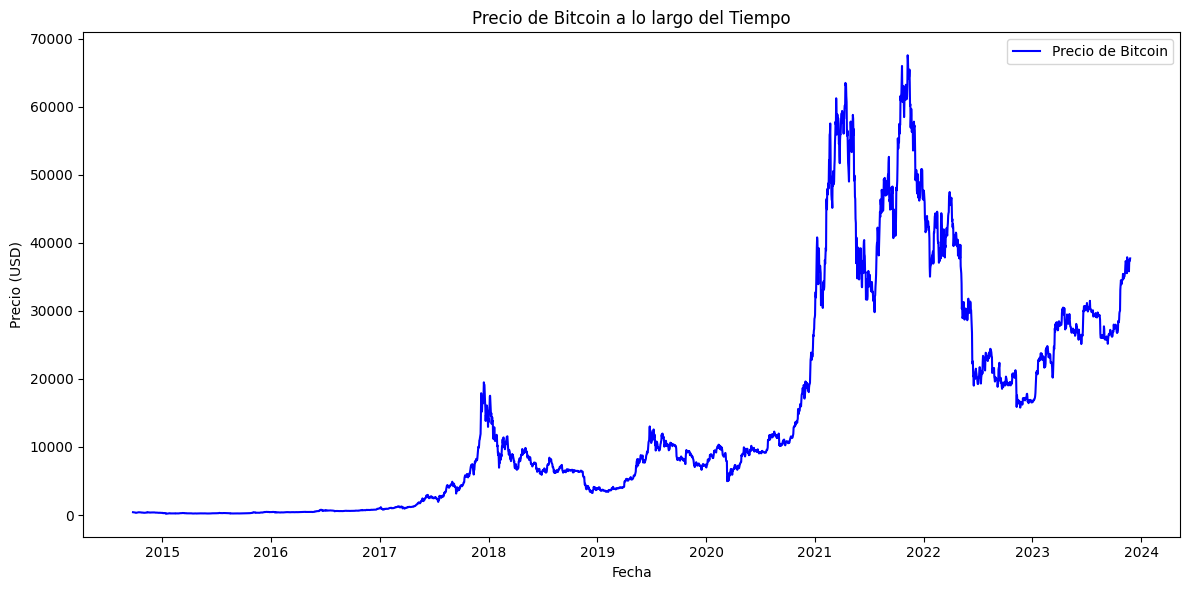

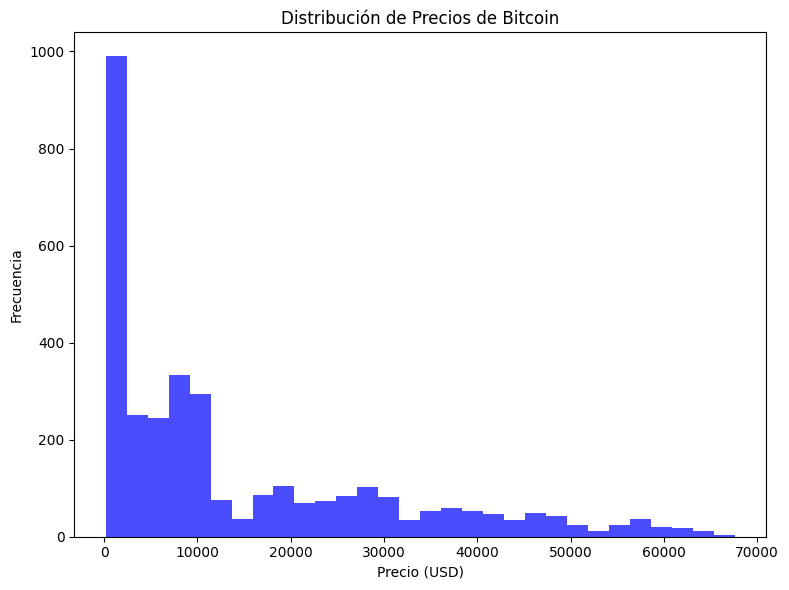

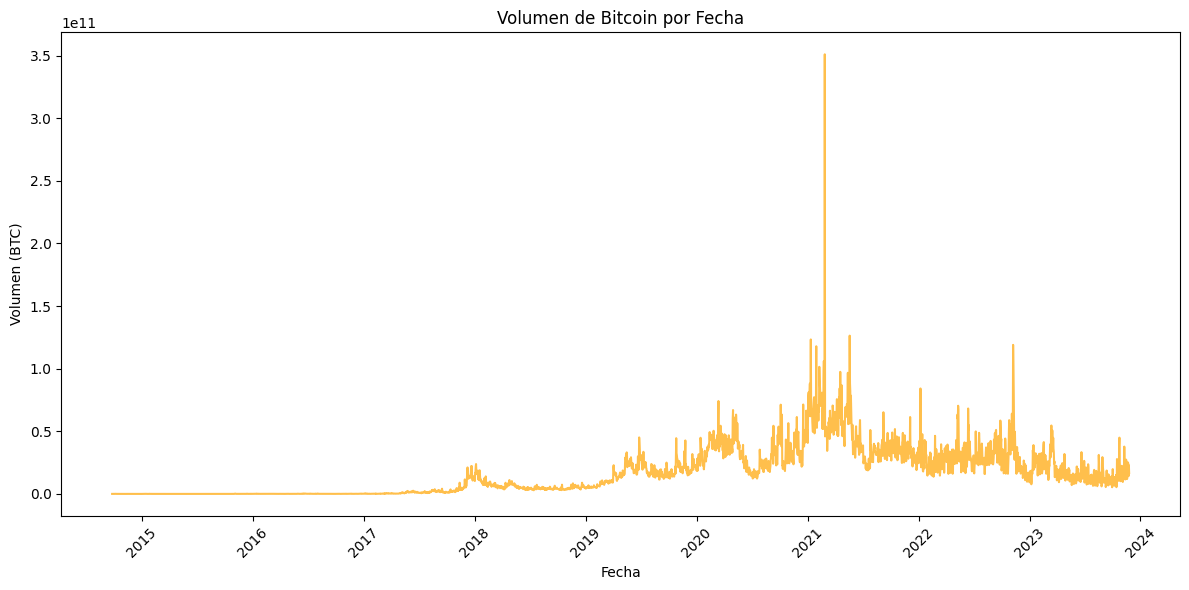

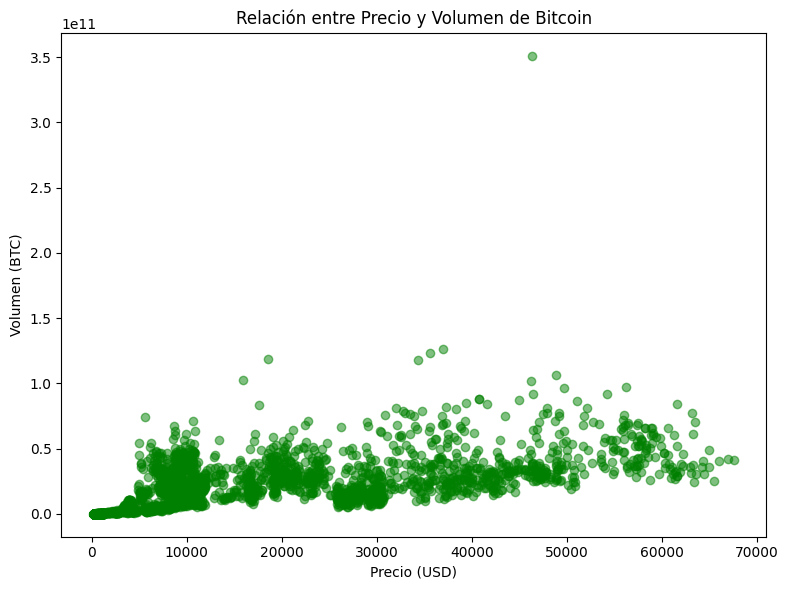

In [ ]:
import matplotlib.pyplot as plt
df=pd.read_csv('/content/drive/MyDrive/BTC-USD (1).csv')
df['Date'] = pd.to_datetime(df['Date'])
df=df.drop(columns=['Adj Close'])

print(df.head())

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label='Precio de Bitcoin', color='b')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.title('Precio de Bitcoin a lo largo del Tiempo')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df['Close'], bins=30, color='b', alpha=0.7)
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precios de Bitcoin')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Volume'], color='orange', alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Volumen (BTC)')
plt.title('Volumen de Bitcoin por Fecha')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(df['Close'], df['Volume'], color='green', alpha=0.5)
plt.xlabel('Precio (USD)')
plt.ylabel('Volumen (BTC)')
plt.title('Relación entre Precio y Volumen de Bitcoin')
plt.tight_layout()
plt.show()

In [ ]:
df.shape

(3349, 6)

**PREPARACION DE LOS DATOS**

In [ ]:
# Selecciona las columnas que deseas normalizar
features_to_normalize = df.drop(columns=['Date'])

# Normaliza los datos seleccionados
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features_to_normalize)

# Crea un nuevo DataFrame con las características normalizadas
normalized_df = pd.DataFrame(normalized_features, columns=features_to_normalize.columns)

print(normalized_df.head())

sequence_length = 7  # Longitud de la secuencia
sequences = []
labels = []

# Crea las secuencias y las etiquetas
for i in range(len(normalized_df) - sequence_length-1):
    sequence = normalized_df.iloc[i:i + sequence_length]  # Obtén la secuencia de longitud N
    columnas_numericas = sequence.select_dtypes(include=[np.number])
    sequence_filled = sequence.fillna(columnas_numericas.mean())

    sequence2 = normalized_df.iloc[i+1:i + sequence_length+1]# Obtén la siguiente secuencia de longitud N
    columnas_numericas2 = sequence2.select_dtypes(include=[np.number])
    sequence_filled2 = sequence2.fillna(columnas_numericas2.mean())
    # Obtén target de la siguiente secuencia de longitud N.
    # Si valor es nan nos quedamos con la media de la columna 'close' de la siguiente secuencia(que es la que incluye la serie cuyo 'close' es el target de la secuencia actual)
    if np.isnan( normalized_df.iloc[i + sequence_length]['Close']):
      target = sequence_filled2['Close'].mean()
    else:
      target = normalized_df.iloc[i + sequence_length]['Close']
    sequences.append(sequence_filled.values)  # Agrega la secuencia como un array de NumPy
    labels.append([target])

# Convierte las listas de secuencias y etiquetas en arrays de NumPy para usar en el modelo
sequences = np.array(sequences)
labels = np.array(labels)


       Open      High       Low     Close    Volume
0 -0.866732 -0.866688 -0.868636 -0.868052 -0.860818
1 -0.867464 -0.867211 -0.869242 -0.868498 -0.861097
2 -0.867955 -0.867718 -0.869412 -0.868804 -0.861433
3 -0.868210 -0.868059 -0.870890 -0.870198 -0.860985
4 -0.869616 -0.869022 -0.871024 -0.870305 -0.860522


In [ ]:
sequences.shape, labels.shape


((3341, 7, 5), (3341, 1))

**RED LSTM**

Creamos modelo LSTM teniendo en cuenta la forma de los datos que en nuestro caso es (1400,8). Primero creamos LSTM con return_sequences=True para obtener todos los estados. Despues usamos otra LSTM pero con return_sequences=False para asi obtener solo el ultimo estado. Por último utilizamos capa densa de salida con sigmoide como funcion de activacion.

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, SimpleRNN, LSTM, Dropout
model = Sequential()
model.add(LSTM(256, input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(64))
model.add(Dense(128))
model.add(Dense(32))
model.add(Dense(1, kernel_initializer='normal'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 7, 256)            268288    
                                                                 
 lstm_21 (LSTM)              (None, 7, 64)             82176     
                                                                 
 lstm_22 (LSTM)              (None, 64)                33024     
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 395969 (1.51 MB)
Trainable params: 39596

Compilamos ,entrenamos y evaluamos el modelo (utilizamos los 5000 primeras secuencias para entrenamiento, las siguientes 3000 para la validación y el resto para la evaluacion).\
Utilizamos adam como optimizador ya que el learning rate se va actualizando y mae como funcion de perdida ya que es la media de la diferencia absoluta entre cada predicción y su valor real(también habría sido posible utilizar el mse que es el sumatorio de la diferencias al cuadrado entre cada predicción y su valor real).

In [ ]:
model.compile(optimizer='adam', loss='mae')

history = model.fit(sequences[:3000], labels[:3000], epochs=100, batch_size=32, validation_data=(sequences[3000:3200], labels[3000:3200]))

Epoch 1/100
94/94 [==============================] - 7s 19ms/step - loss: 0.1671 - val_loss: 0.0660
Epoch 2/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0706 - val_loss: 0.0571
Epoch 3/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0603 - val_loss: 0.0727
Epoch 4/100
94/94 [==============================] - 1s 8ms/step - loss: 0.0661 - val_loss: 0.0665
Epoch 5/100
94/94 [==============================] - 1s 12ms/step - loss: 0.0626 - val_loss: 0.0540
Epoch 6/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0591 - val_loss: 0.0520
Epoch 7/100
94/94 [==============================] - 1s 10ms/step - loss: 0.0500 - val_loss: 0.0518
Epoch 8/100
94/94 [==============================] - 1s 11ms/step - loss: 0.0497 - val_loss: 0.0543
Epoch 9/100
94/94 [==============================] - 1s 11ms/step - loss: 0.0503 - val_loss: 0.0505
Epoch 10/100
94/94 [==============================] - 1s 12ms/step - loss: 0.0468 - val_loss: 0.0456
Ep

In [ ]:
model.evaluate(sequences[3200:], labels[3200:])

5/5 [==============================] - 0s 7ms/step - loss: 0.0253


0.025325579568743706

Visualizamos evolucion de train_loss y val_loss a lo largo de las epochs para ver si se produce overfitting

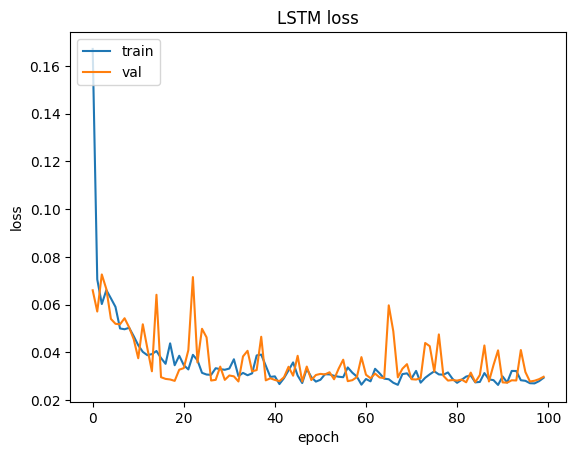

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

5/5 [==============================] - 1s 4ms/step
(141, 1)


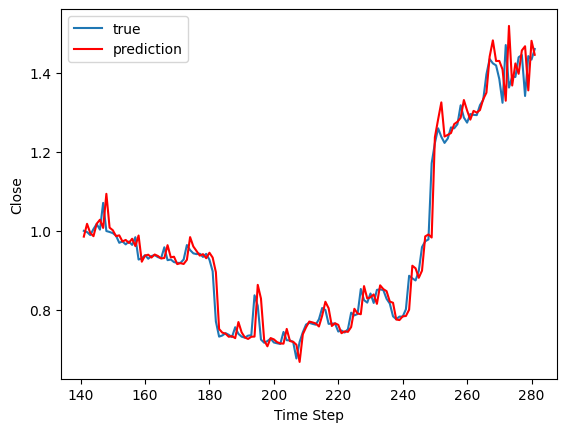

In [ ]:
ypred_shape=model.predict(sequences[3200:])
print(ypred_shape.shape)
# plt.plot(np.arange(0, len(y_CO_train_shape)), y_CO_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(labels[3200:]), len(labels[3200:]) + len(labels[3200:])), labels[3200:].flatten(), label="true")
plt.plot(np.arange(len(labels[3200:]), len(labels[3200:]) + len(labels[3200:])), ypred_shape.flatten(), 'r', label="prediction")
plt.ylabel('Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
from keras.metrics import mean_squared_error,mean_absolute_error

medias = df['Close'].mean()
desviaciones_estandar = df['Close'].std()

ypred_shape = ypred_shape * desviaciones_estandar + medias
labels = labels * desviaciones_estandar + medias

print("Train data MSE: ", np.array(mean_squared_error(labels[3200:].flatten(),ypred_shape.flatten())))
print("Train data MAE: ", np.array(mean_absolute_error(labels[3200:].flatten(),ypred_shape.flatten())))

Train data MSE:  438066.72
Train data MAE:  405.94757


In [ ]:
normalized_df = normalized_df.drop(normalized_df.tail(1).index)
ultimas_8filas = normalized_df.tail(7)
ultimas_8filas=ultimas_8filas.reset_index()
ultimas_8filas=ultimas_8filas.drop(columns=['index'])
ultimas_8filas

,Open,High,Low,Close,Volume
0,1.392165,1.351589,1.429600,1.389056,-0.242055
1,1.389694,1.392407,1.441230,1.439025,-0.188316
2,1.438882,1.407481,1.471250,1.444666,0.227640
3,1.444815,1.399826,1.402687,1.340894,0.451158
4,1.337954,1.413583,1.393524,1.441883,0.410727
5,1.441774,1.400604,1.473901,1.432978,-0.120542
6,1.434030,1.447595,1.495569,1.459849,0.333804


In [ ]:
sequences2 = []

# Crea las secuencias y las etiquetas
for i in range(1):
    sequence2 = ultimas_8filas.iloc[i:i + sequence_length]
    sequences2.append(sequence2.values)  # Agrega la secuencia como un array de NumPy


# Convierte las listas de secuencias y etiquetas en arrays de NumPy para usar en el modelo
sequences2 = np.array(sequences2)
sequences2.shape

(1, 7, 5)

In [ ]:
# Realiza las predicciones con el modelo
predicciones_normalizadas = model.predict(sequences2)

predicciones_desnormalizadas = predicciones_normalizadas * desviaciones_estandar + medias

print(predicciones_desnormalizadas)

1/1 [==============================] - 0s 27ms/step
[[38265.133]]


**RED RNN**

Creamos modelo RNN teniendo en cuenta la forma de los datos que en nuestro caso es (1400,8). Primero creamos SimpleRNN con return_sequences=True para obtener todos los estados. Despues usamos otra SimpleRNN pero con return_sequences=False para asi obtener solo el ultimo estado. Por último utilizamos capa densa de salida con sigmoide como funcion de activacion.

In [ ]:
model2 = Sequential()
model2.add(SimpleRNN(64, input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=True))
model2.add(SimpleRNN(64, return_sequences=True))
model2.add(SimpleRNN(64))
model2.add(Dense(1, kernel_initializer='normal'))
model2.summary()

Compilamos, entrenamos y evaluamos el modelo (utilizamos los 5000 primeras secuencias para entrenamiento, las siguientes 3000 para la validación y el resto para la evaluacion).\
Utilizamos adam como optimizador ya que el learning rate se va actualizando y mae como funcion de perdida ya que es la media de la diferencia absoluta entre cada predicción y su valor real(también habría sido posible utilizar el mse que es el sumatorio de la diferencias al cuadrado entre cada predicción y su valor real).

In [ ]:
model2.compile(optimizer='adam', loss='mae')

history2 = model2.fit(sequences[200:3000], labels[200:3000], epochs=10, batch_size=16, validation_data=(sequences[3000:3200], labels[3000:3200]))

In [ ]:
model2.evaluate(sequences[3200:], labels[3200:])

Visualizamos evolucion de train_loss y val_loss a lo largo de las epochs para ver si se produce overfitting

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('RNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
ypred_shape=model2.predict(sequences[3200:])
print(ypred_shape.shape)
# plt.plot(np.arange(0, len(y_CO_train_shape)), y_CO_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(labels[3200:]), len(labels[3200:]) + len(labels[3200:])), labels[3200:].flatten(), label="true")
plt.plot(np.arange(len(labels[3200:]), len(labels[3200:]) + len(labels[3200:])), ypred_shape.flatten(), 'r', label="prediction")
plt.ylabel('Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Añadimos Dropout para evitar sobreajuste

In [ ]:
model2 = Sequential()
model2.add(SimpleRNN(32, input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=True))
model2.add(Dropout(0.2))
model2.add(SimpleRNN(32, return_sequences=True))
model2.add(SimpleRNN(32))
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

In [ ]:
model2.compile(optimizer='adam', loss='mae')

history = model2.fit(sequences[:10000], labels[:10000], epochs=10, batch_size=100, validation_data=(sequences[10000:16000], labels[10000:16000]))

In [ ]:
model2.evaluate(sequences[16000:], labels[16000:])

**RED GRU**

In [ ]:
from keras.layers import GRU

model3 = Sequential()
model3.add(GRU(128, input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=True))
model3.add(GRU(64, return_sequences=True))
model3.add(GRU(64))
model3.add(Dense(1, kernel_initializer='normal'))
model3.summary()

In [ ]:
model3.compile(optimizer='adam', loss='mae')

history3 = model3.fit(sequences[500:3000], labels[500:3000], epochs=32, batch_size=32, validation_data=(sequences[3000:3200], labels[3000:3200]))

In [ ]:
model3.evaluate(sequences[3200:], labels[3200:])

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('GRU loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
ypred_shape=model3.predict(sequences[3200:3270])
print(ypred_shape.shape)
# plt.plot(np.arange(0, len(y_CO_train_shape)), y_CO_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(labels[3200:3270]), len(labels[3200:3270]) + len(labels[3200:3270])), labels[3200:3270].flatten(), label="true")
plt.plot(np.arange(len(labels[3200:3270]), len(labels[3200:3270]) + len(labels[3200:3270])), ypred_shape.flatten(), 'r', label="prediction")
plt.ylabel('Close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

**CONCLUSIONES**


Como podemos obserbar el modelo que mejor esta funcionando es el GRU, después el RNN y por ultimo el LSTM (otras veces que he ejecutado el codigo el LSTM ha sido el que ha dado un mejor resultado). Sin embargo el unico suficientemente bueno como para hacer una predicion en condiciones del precio de cierre de btc es el GRU y esta predicion no llega a ser buena del todo(a mi gusto faltan variables dependientes para hacer una buena prediccion).\
También con las primeras graficas nos damos cuenta de que el rango de precio en el que mas tiempo ha estado btc es entre 0 y 2000(a partir de ahi el resto de rangos bajan drásticamente en frecuencia de datos), por tanto la mayoria de las series temporales cierran en ese rango. Yo creo que convendría coger menos datos del inicio para igualar la cantidad de datos en todos los rangos de tiempo, por ello a la hora de preparar los datos y crear las secuencias y etiquetas he empezado a partir de un numero hasta la longitud del df entero(no obstante como eran muchos datos no he podido coger el rango que me habria gustado).

